In [1]:
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import sys
import matplotlib.pyplot as plt

from tqdm.auto import trange
from copy import deepcopy
from itertools import cycle

sys.path.append("../lib")

from nf.NF_base import *
from nf.realnvp import *
from swgf_mynf import SWGF as swgf_nf
from swgf_mlp import SWGF as swgf_mlp
from sw import *
from nf.utils_nf import log_likelihood
from utils_imgs.utils import uniform_quantization, rescale_logit, inverse_logit, val_mnist, val_mnist_ae
from networks.autoencoder import *
from swgf_cnn import SWGFCNN

from fid_score import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Without Autoencoder

### Utils - MNIST

In [4]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

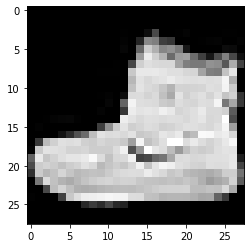

In [5]:
plt.imshow(inverse_logit(train_dataset[0][0]).reshape(28,28),"gray")
plt.show()

In [6]:
rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

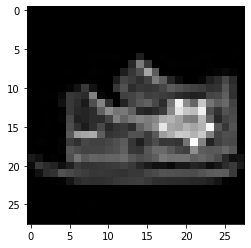

In [7]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = inverse_logit(data[:,0])
    cpt += 32

plt.imshow(real_cpu[-1],"gray")
plt.show()

### Gradient Flow in data logit space

In [9]:
def create_RealNVP_BatchNorm(nh=1024, nl=5, d=784):
    shiftings = [shifting(d//2,nh,d//2,1) for k in range(nl)]
    scalings = [scaling(d//2,nh,d//2,1) for k in range(nl)]

    flows = []
    for i in range(nl):
        flows.append(AffineCoupling(scalings[i],shiftings[i],d))
        flows.append(Reverse(d))
        flows.append(BatchNorm(d))

    model = NormalizingFlows(flows).to(device)
    return model

#### With entropy

In [13]:
def J(x, z, log_det):
    batch_size = x.size(0)
    target = next(dataiter)[0].reshape(-1,28*28).to(device)
    
    sw = sliced_wasserstein(x, target, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    h = torch.mean(log_likelihood(z, log_det, device),axis=0) ## entropy
#     print((sw/2).item(), (1e-4*h).item())
    return sw/2+1e-7*h

t_init = 0
t_end = 10
h = 1

n_steps = int(np.ceil((t_end-t_init)/h))

d = 784

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-2 * np.ones(n_steps)
# lrs[0] = 5e-3

n_epochs = 500 * np.ones(n_steps)
n_epochs[0] = 1500
n_epochs[1] = 1000

Lrho = swgf_nf(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
               J=J, create_NF=create_RealNVP_BatchNorm, nh=1024, nl=5, lrs=lrs, 
               num_projections=1000, n_samples=1000, plot_loss=False, 
               tqdm_bar=True)

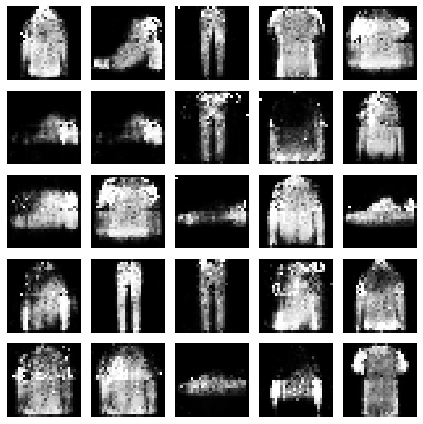

In [14]:
val_mnist(Lrho[-1], device)

In [15]:
z = torch.randn(10000, 28*28, device=device)
zs, _ = Lrho[-1](z)
gen_imgs = inverse_logit(zs[-1].reshape(-1,28,28,1).detach().cpu())

In [16]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

./lib/fid_score.py:182: UserWarning: FID score: the values of images should be in range [0,1].
  warnings.warn('FID score: the values of images should be in range [0,1].')


116.06592049623549

#### Without entropy

In [14]:
def J(x, z, log_det):
    batch_size = x.size(0)
    target = next(dataiter)[0].reshape(-1,28*28).to(device)
    
    sw = sliced_wasserstein(x, target, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    h = torch.mean(log_likelihood(z, log_det, device),axis=0) ## entropy
    return sw/2

In [15]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 784

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-2 * np.ones(n_steps)
lrs[0] = 1e-2

n_epochs = 500 * np.ones(n_steps)
n_epochs[0] = 1500
n_epochs[1] = 1000

Lrho = swgf_nf(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
               J=J, create_NF=create_RealNVP, nh=512, nl=2, lrs=lrs, 
               num_projections=1000, n_samples=1000, plot_loss=False, tqdm_bar=True)

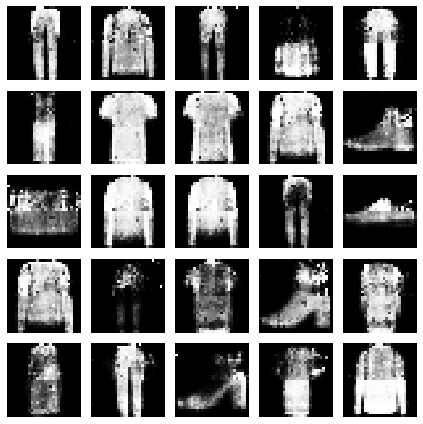

In [16]:
val_mnist(Lrho[-1], device)

1 5


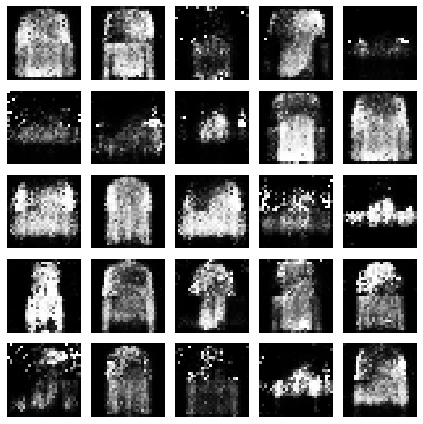

2 10


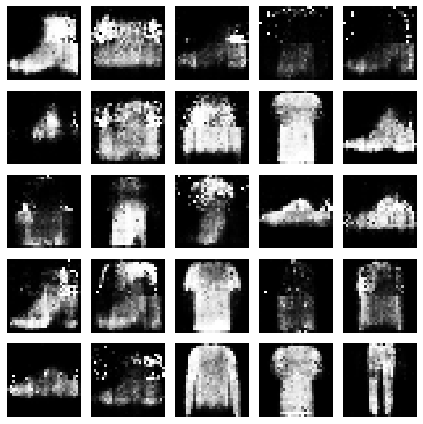

3 15


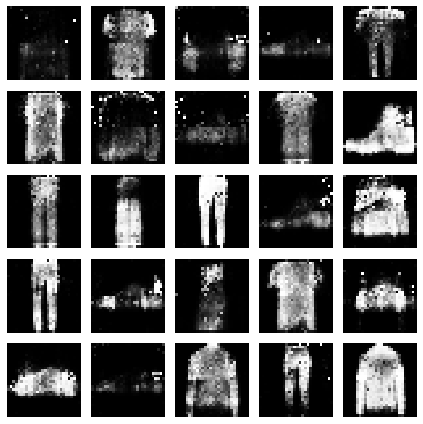

4 20


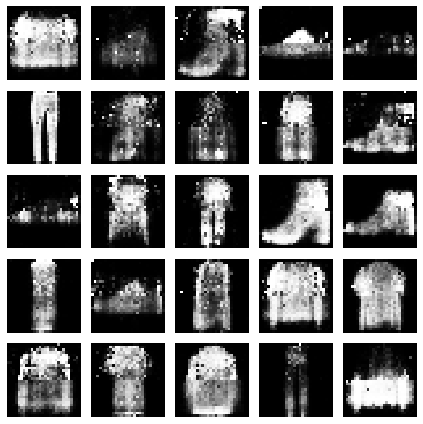

5 25


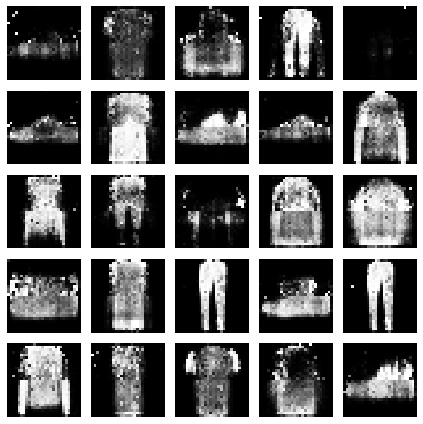

6 30


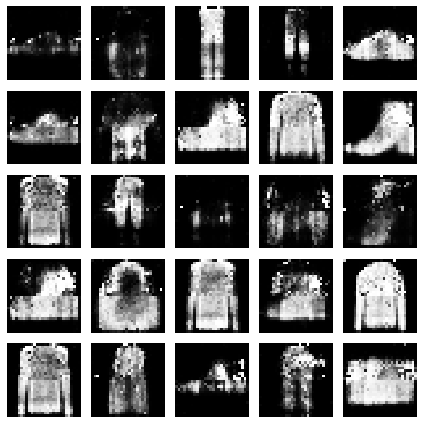

7 35


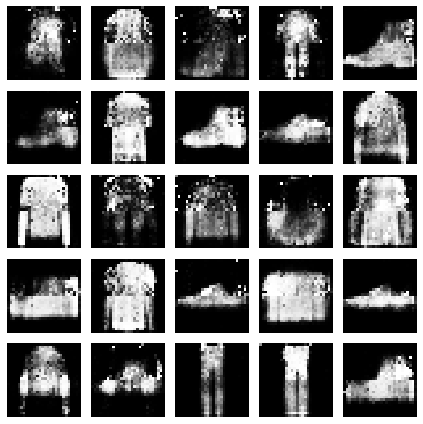

8 40


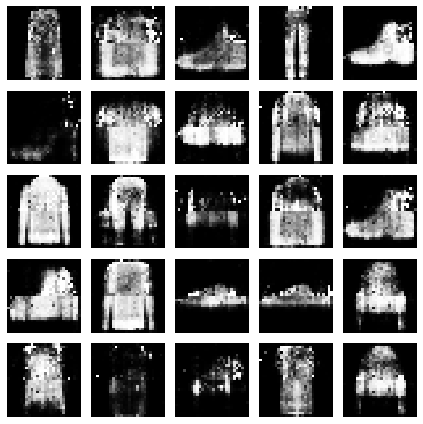

9 45


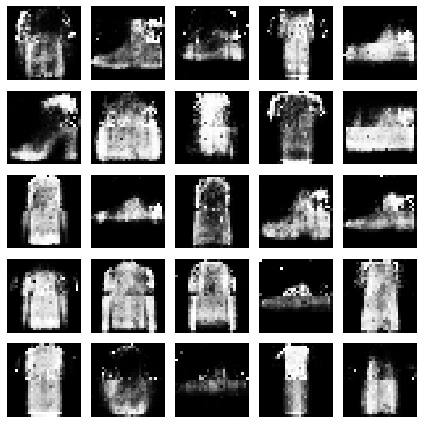

10 50


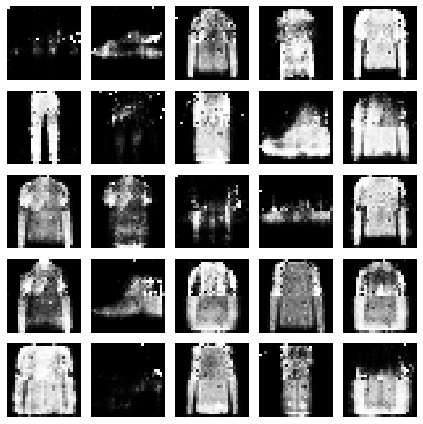

11 55


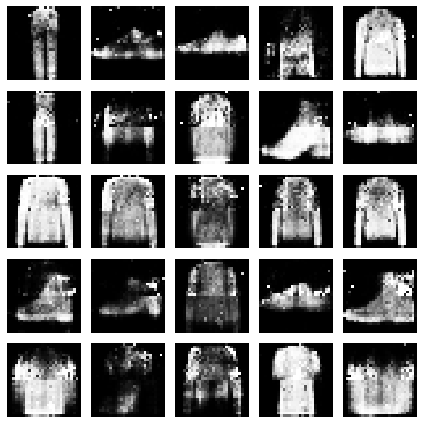

12 60


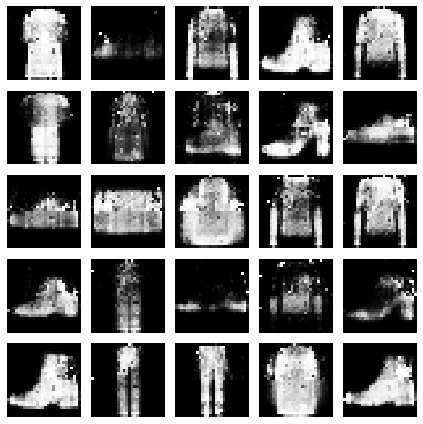

13 65


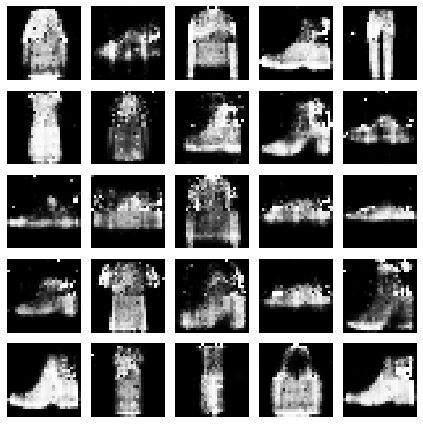

14 70


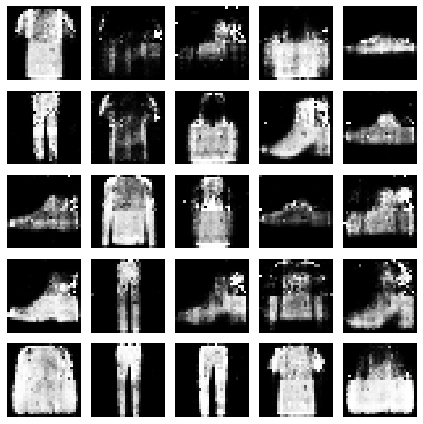

15 75


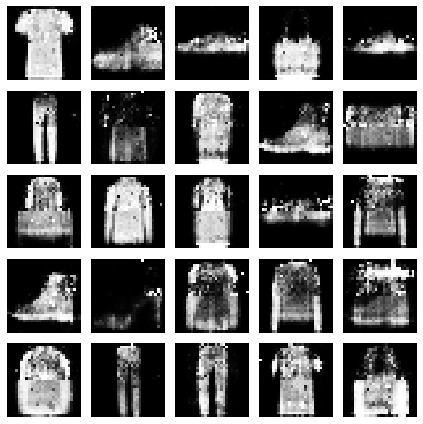

16 80


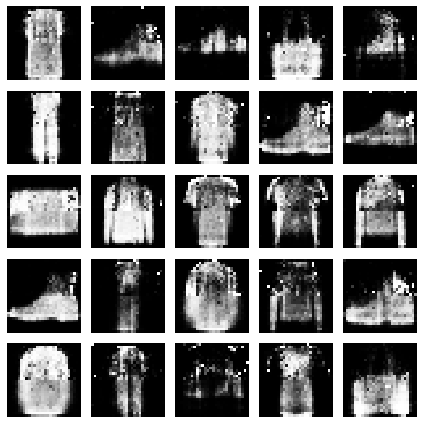

17 85


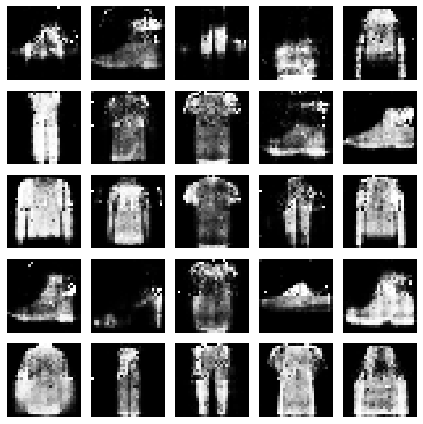

18 90


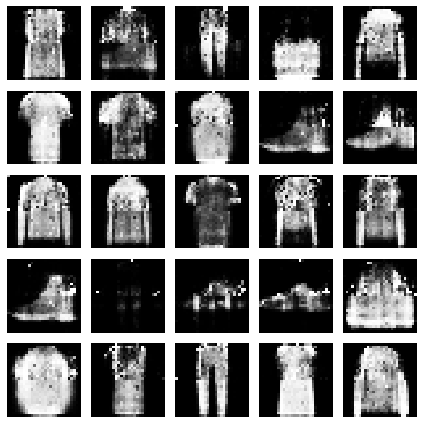

19 95


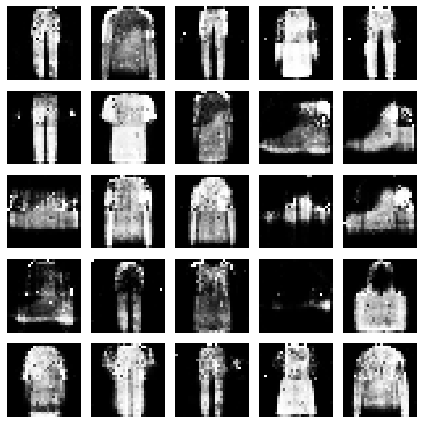

20 100


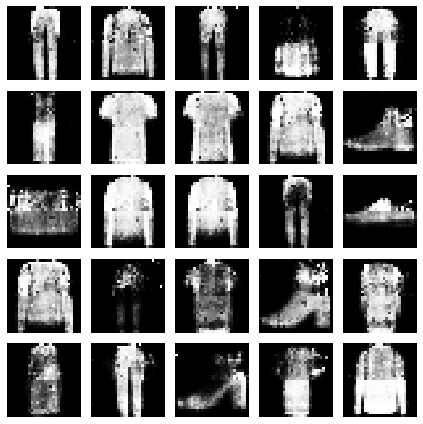

In [17]:
for k in range(1,len(Lrho)):
    print(k,k*h)
    val_mnist(Lrho[k], device)

In [18]:
z = torch.randn(10000, 28*28, device=device)
zs, _ = Lrho[-1](z)
gen_imgs = inverse_logit(zs[-1].reshape(-1,28,28,1).detach().cpu())

In [19]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

95.50457220247546

#### With MLP

In [20]:
class mlp(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

In [21]:
def J(rho):
    z = torch.randn(128, 28*28, device=device)
    x = rho(z)
    
    target = next(dataiter)[0].reshape(-1,28*28).to(device)
    
    sw = sliced_wasserstein(x, target, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [22]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 784

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-3 * np.ones(n_steps)
lrs[0] = 5e-3

n_epochs = 500 * np.ones(n_steps)
n_epochs[0] = 1000
# n_epochs[1] = 1000

Lrho = swgf_mlp(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
                J=J, create_nn=mlp, nh=512, nl=5, lrs=lrs, 
                num_projections=1000, n_samples=1000, plot_loss=False, tqdm_bar=True)

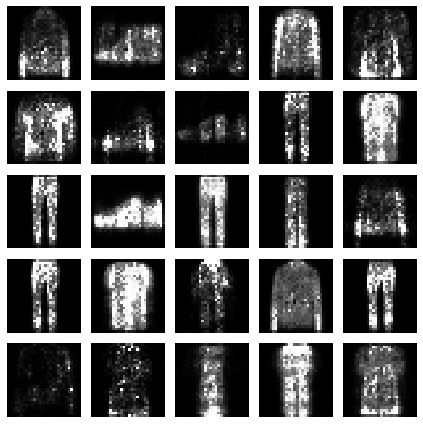

In [24]:
val_mnist(Lrho[-1], device)

1 5


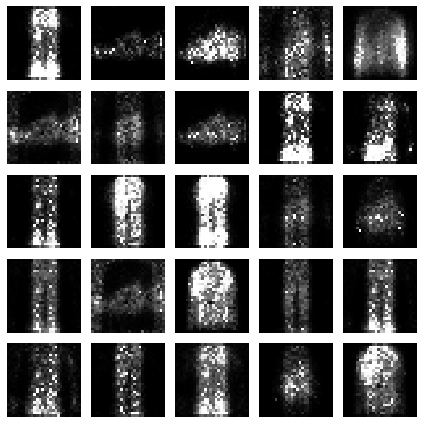

2 10


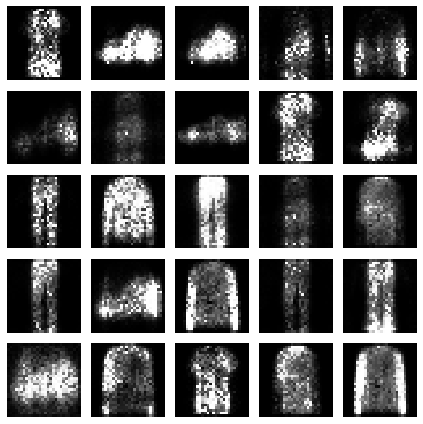

3 15


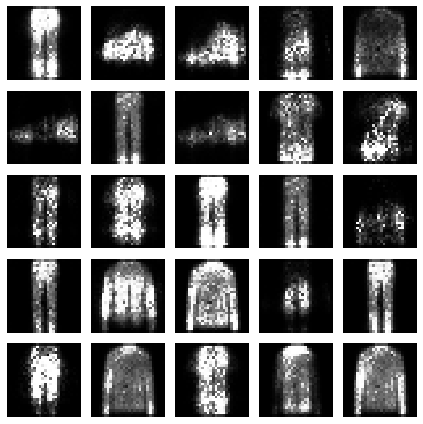

4 20


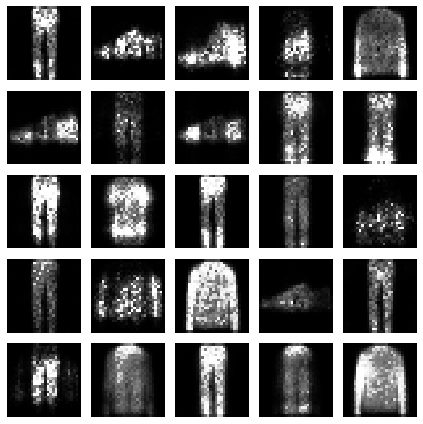

5 25


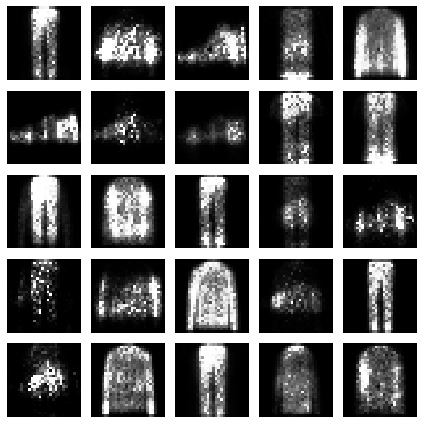

6 30


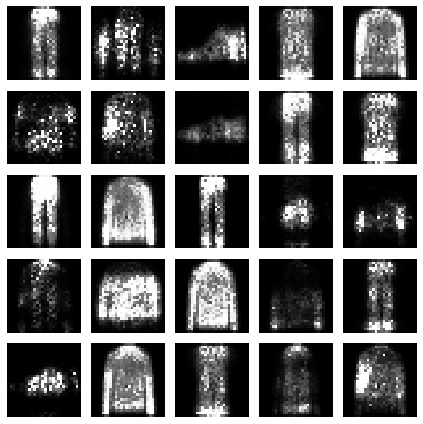

7 35


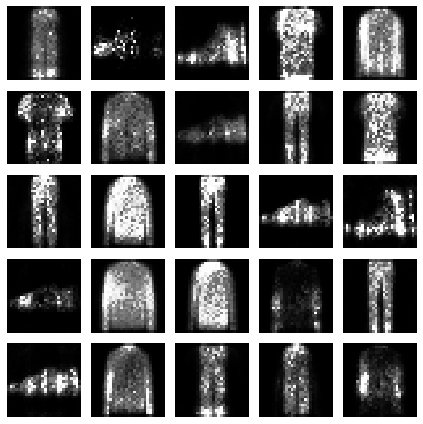

8 40


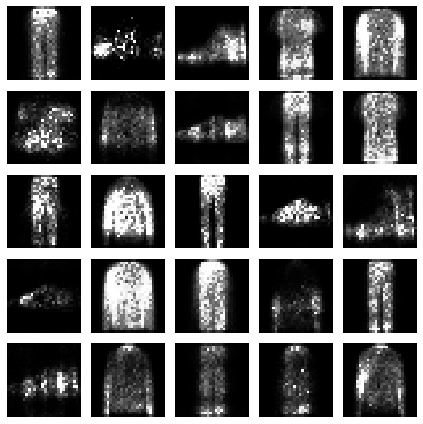

9 45


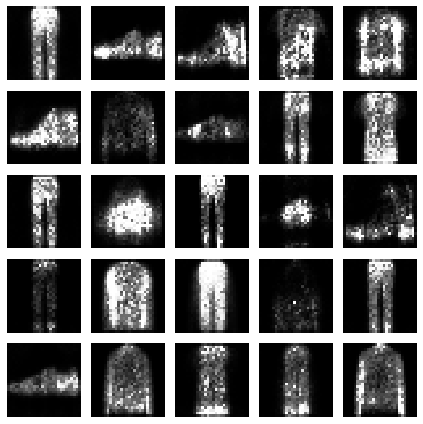

10 50


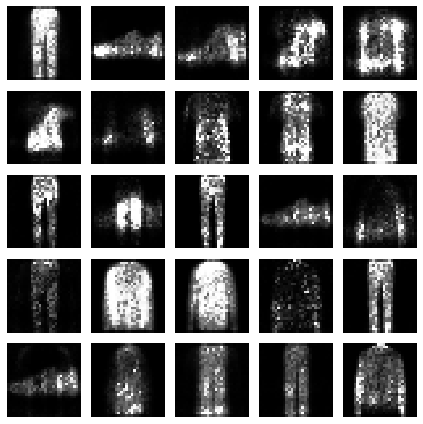

11 55


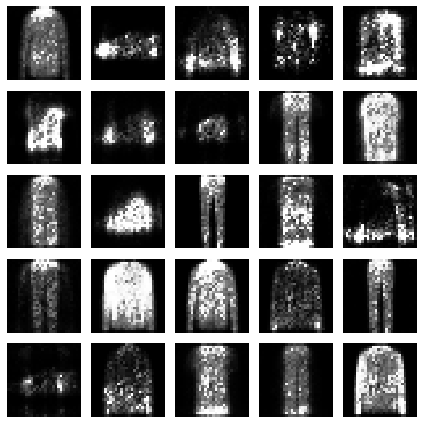

12 60


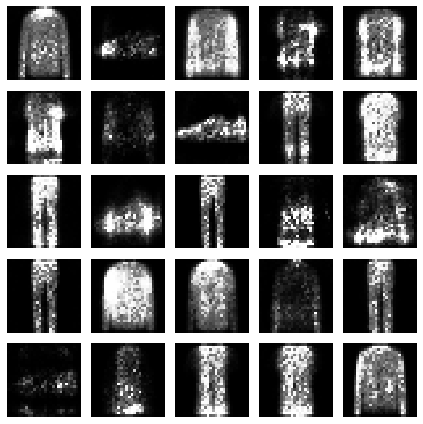

13 65


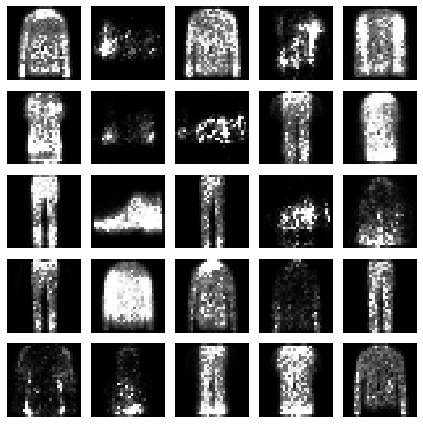

14 70


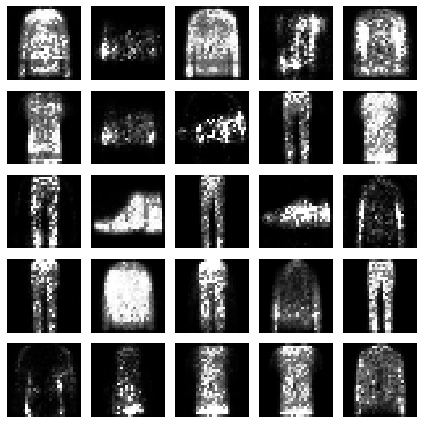

15 75


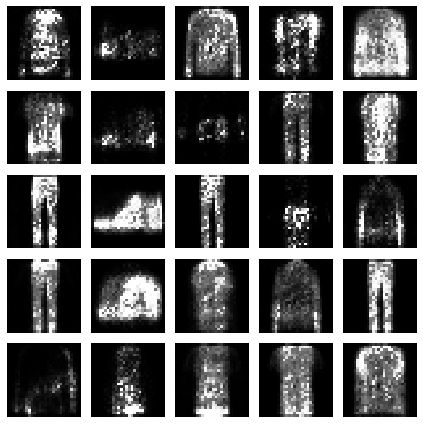

16 80


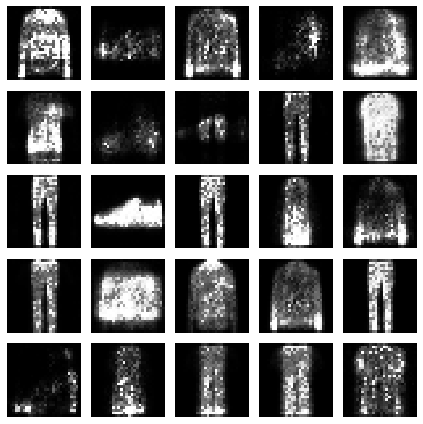

17 85


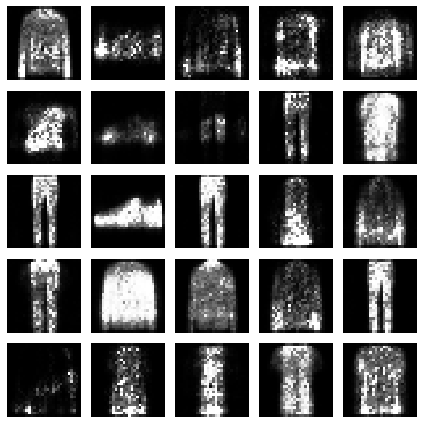

18 90


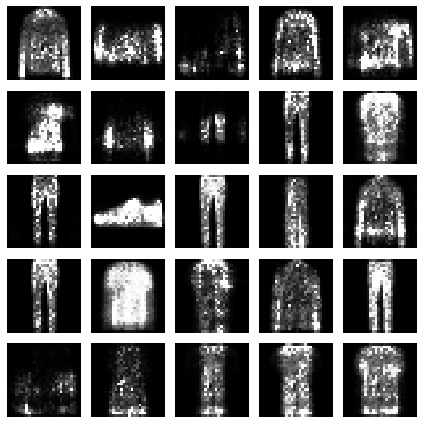

19 95


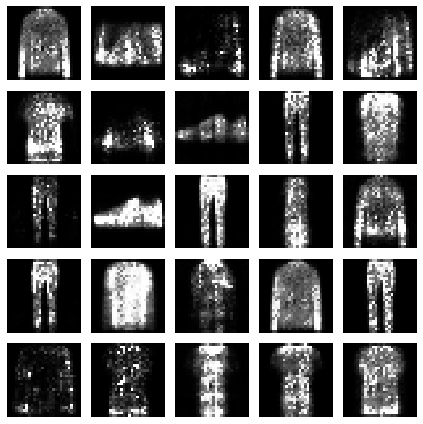

20 100


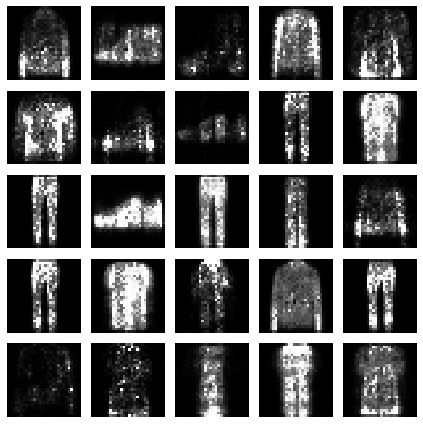

In [25]:
for k in range(1,len(Lrho)):
    print(k,k*h)
    val_mnist_nn(Lrho[k], device)

In [26]:
z = torch.randn(10000, 28*28, device=device)
zs = Lrho[-1](z)
gen_imgs = inverse_logit(zs.reshape(-1,28,28,1).detach().cpu())

In [27]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

182.31421891298123

#### With CNNs

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
#                 uniform_quantization,
#                 rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [4]:
rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

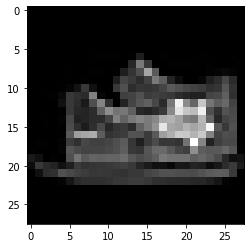

In [5]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = data[:,0]
    cpt += 32

plt.imshow(real_cpu[-1],"gray")
plt.show()

In [9]:
def J(rho):
    z = torch.randn(128, 100, 1, 1, device=device)
    x = rho(z)
    
    target = next(dataiter)[0].reshape(-1,28*28).to(device)
    
    sw = sliced_wasserstein(x.reshape(-1,28*28), target, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [11]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 784

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

# lrs = 1e-3 * np.ones(n_steps)
# lrs[0] = 5e-3

lrs = 1e-3

n_epochs = 500 * np.ones(n_steps)
n_epochs[0] = 1000
# n_epochs[1] = 1000

Lrho = SWGFCNN(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
                J=J, d_latent=100, lrs=lrs, 
                num_projections=1000, n_samples=1000, plot_loss=False, 
                tqdm_bar=True)

/share/common/anaconda3/envs/python37/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


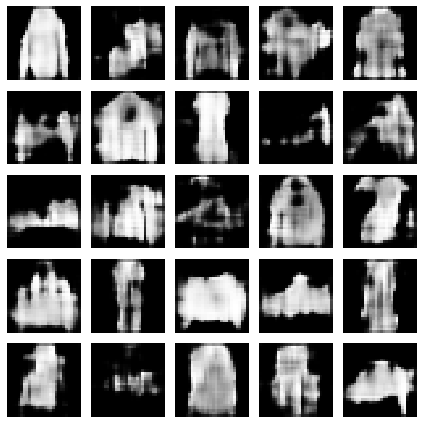

In [12]:
val_mnist(Lrho[-1], device)

In [13]:
z = torch.randn(10000, 100, 1, 1, device=device)
zs = Lrho[-1](z)
# gen_imgs = inverse_logit(zs.reshape(-1,28,28,1).detach().cpu())
gen_imgs = zs.reshape(-1,28,28,1).detach().cpu()

In [14]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

102.28501767493725

## With Autoencoder

### Utils Mnist

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)



rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

In [4]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = data[:,0]
    cpt += 32

# plt.imshow(real_cpu[-1],"gray")
# plt.show()

### Autoencoder

In [5]:
criterion = nn.BCELoss(reduction='sum')

def ae_loss(x, y):
    reconstruction_loss = criterion(y, x)    
    return reconstruction_loss

In [6]:
model = AE(train_loader.dataset[0][0].shape, 48).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

  0%|          | 0/201 [00:00<?, ?it/s]

0 282.68679790049475 237.2060421099678


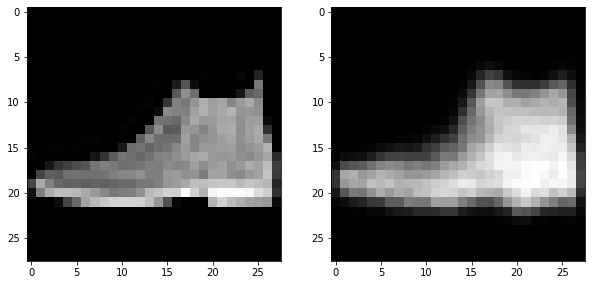

1 230.64748697613007 228.40453033934767
2 225.064958486984 224.87503646509336
3 221.76140487660055 222.02650866036217
4 219.6035824838732 220.18394392214645
5 217.88513559912144 218.97100303576778


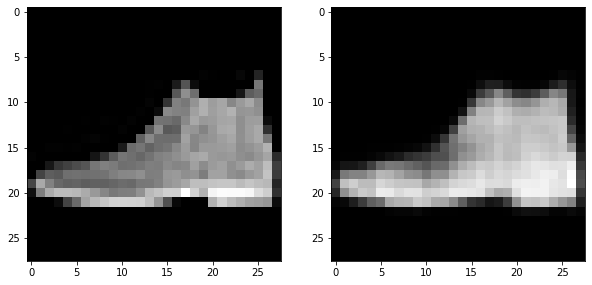

6 216.5869889791417 217.46145698132986
7 215.53901891430473 216.791962498674
8 214.6407389040949 215.86751056707706
9 213.94686742157657 215.21042186992997
10 213.42083400788678 214.74179355024148


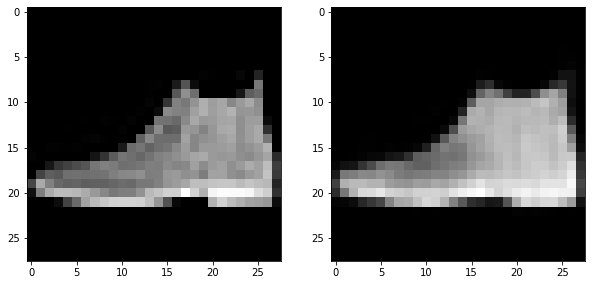

11 212.86749509419627 214.28282146027294
12 212.35730081326417 214.12656034524449
13 211.96735469381608 213.43351404354596
14 211.62021430367346 213.035638681235
15 211.3675272710457 212.87267895780812


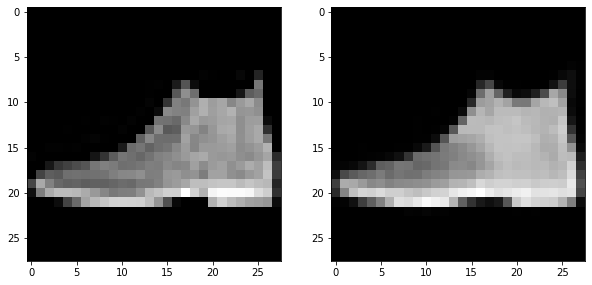

16 211.02938898082482 212.51481448042506
17 210.6557778125972 212.37067420642597
18 210.5094100637646 212.10423069183057
19 210.2901725199685 212.4429442189372
20 210.05036765764856 212.39091111448246


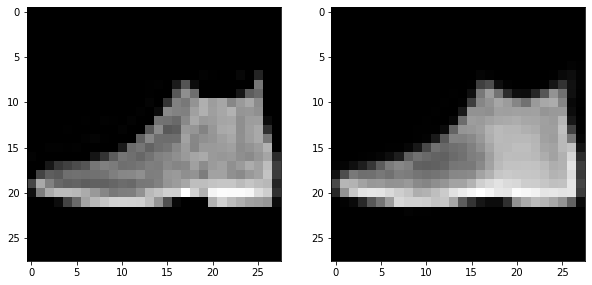

21 209.82713711541345 211.69077927464494
22 209.7086178712499 211.6425908975327
23 209.51689298693475 211.4430163691219
24 209.34342548774336 211.18683982580995
25 209.3140637927133 211.19711693711935


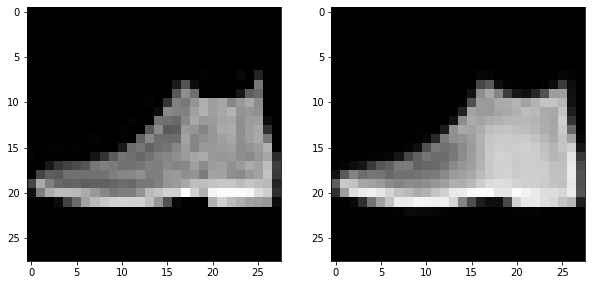

26 209.060069373591 211.03206622333954
27 208.94326256248402 210.8633616389558
28 208.88867628887857 210.63807692847695
29 208.69415104262103 210.35989501758124
30 208.60600441266394 210.51695266089882


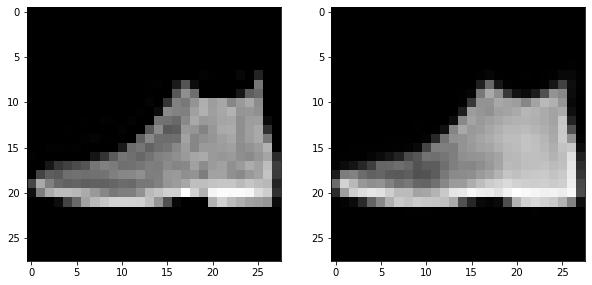

31 208.4870552654036 210.36734779041035
32 208.3967493920777 210.38776814518644
33 208.34277390383113 210.2991561645898
34 208.1919046603964 210.01025853751185
35 208.14420127190846 210.4172463706507


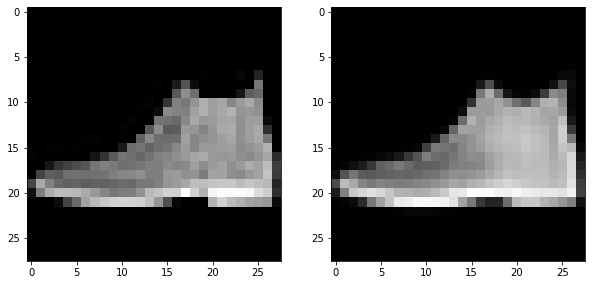

36 208.05312741624607 209.99830334940657
37 207.98940791690615 209.9182359006839
38 207.91782901332832 209.84318220729645
39 207.837144755436 209.69633659387168
40 207.79270451375584 209.61419248733276


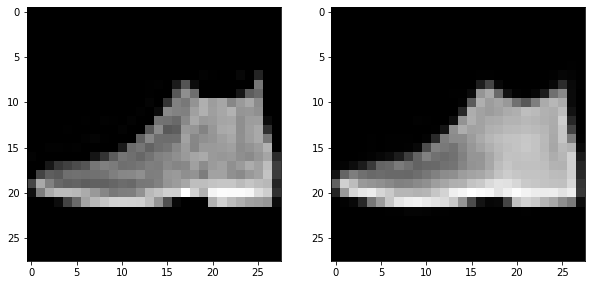

41 207.70104809119164 209.51870727539062
42 207.6558621751559 209.58476008698582
43 207.56391809134087 209.74733190566968
44 207.50612656105977 209.43210496993873
45 207.47692255102834 209.4238053586917


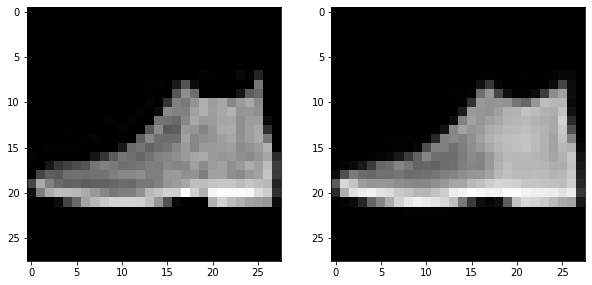

46 207.39088182917027 209.43870715059032
47 207.3444954683023 209.36998258840543
48 207.34418992379412 209.43904264894917
49 207.2531759211927 209.33865975571896
50 207.20358866330318 209.37947872271553


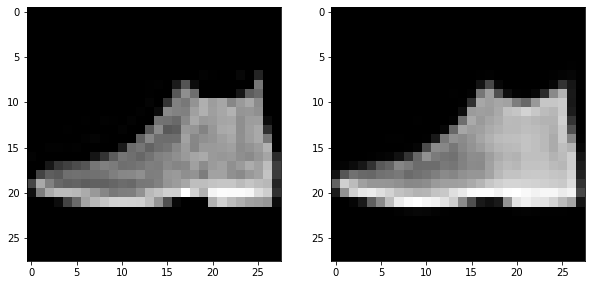

51 207.15112073690906 209.17619933107028
52 207.11598709854744 209.23201237395168
53 207.08261799219235 209.0945869908927
54 207.0373419441055 209.07723024020942
55 206.9728066472187 209.00314818555935


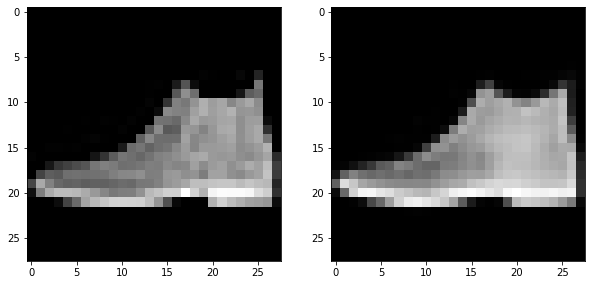

56 206.96669947685885 209.0584917159888
57 206.9148843273171 209.35278159437087
58 206.88959424548227 209.18706792764388
59 206.83513072541868 209.0046561731698
60 206.79839098834788 208.8910126609924


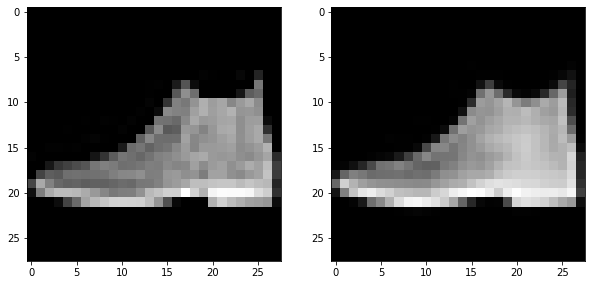

61 206.75357792033483 208.88282166502347
62 206.73687724619785 209.00320317570012
63 206.71176980350063 208.8868321915404
64 206.6451717937933 208.95059321101863
65 206.6791653284047 208.84666447746108


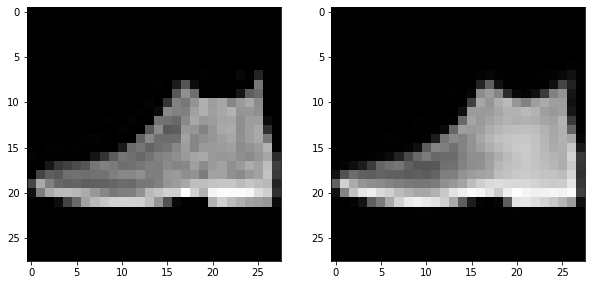

66 206.5901702577202 208.77116993669503
67 206.56207337206615 208.83171710419577
68 206.5366772270067 208.79604810038313
69 206.51407100024085 208.6598909030707
70 206.47295364998044 208.6936951171095


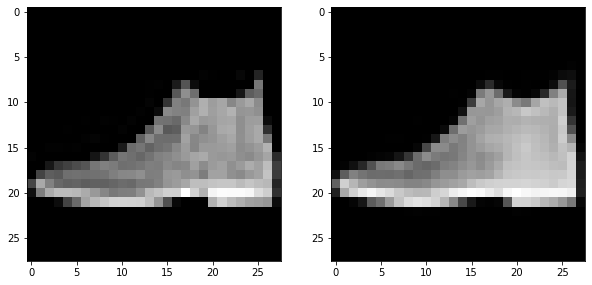

71 206.47647027488117 208.92725009126022
72 206.4285819372897 208.6304107763516
73 206.40339569547282 208.5904356252652
74 206.36796580669127 208.60157931879306
75 206.3861722532705 208.72656557125785


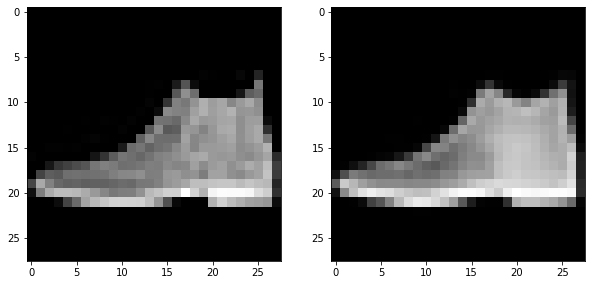

76 206.3010390335224 208.49852589372628
77 206.31628815976964 208.51197322565145
78 206.3005839376985 208.52542475008735
79 206.23618220672932 208.46256438916484
80 206.28014118381654 208.48251805899622


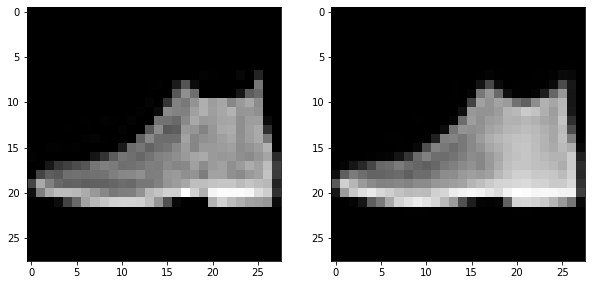

81 206.1805303230638 208.54151536252934
82 206.21038312986548 208.49159903724353
83 206.17931970570555 208.48333540358863
84 206.15950898236218 208.4389691825111
85 206.11785424509705 208.46976497759835


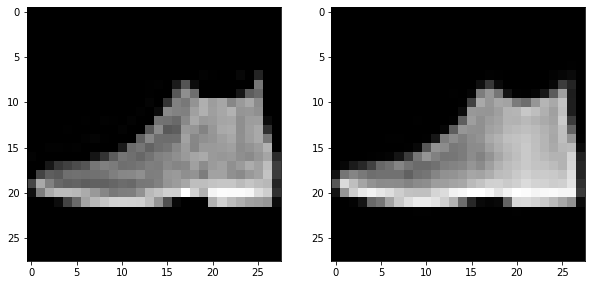

86 206.1279203717219 208.6808385879468
87 206.0777019291968 208.4205905804619
88 206.06571667636635 208.4670327768539
89 206.05938065670532 208.46894387924632
90 206.02248563136118 208.32025048984124


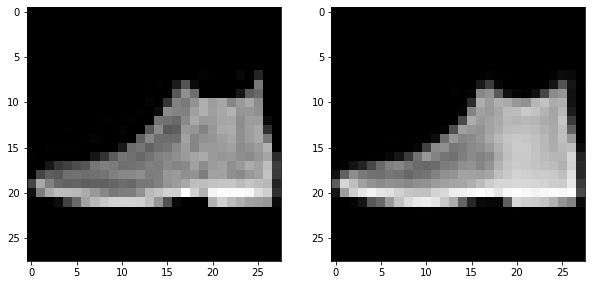

91 205.98906393803514 208.28388489549533
92 205.99226301311177 208.33867818326615
93 205.9913307195364 208.30066249469598
94 205.92221111631088 208.1913594498802
95 205.94471162688927 208.21337563999163


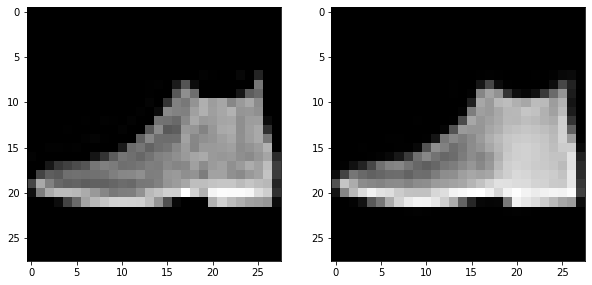

96 205.912744745771 208.26439181684304
97 205.93068014550224 208.31099912990777
98 205.8699739262324 208.20888585099777
99 205.85527936532807 208.24133222781052
100 205.84384225765356 208.15362295327475


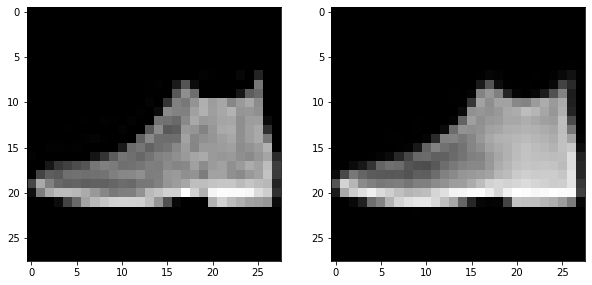

101 205.85160085844842 208.19183208234014
102 205.81672103437194 208.1566262534632
103 205.77206220267593 208.23381310606155
104 205.79760601203665 208.2262912055555
105 205.79457772261043 208.29135663212298


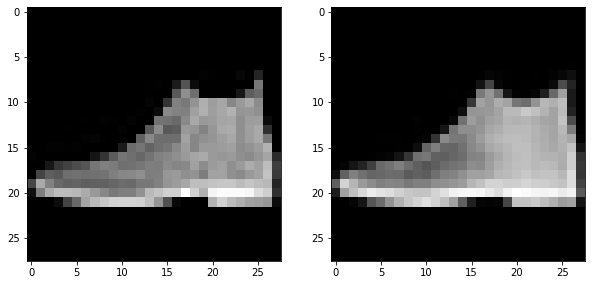

106 205.74179182344068 208.30551045085676
107 205.73191523331656 208.01912462520903
108 205.72905463874127 208.26861455265325
109 205.71368965631524 208.1643091756315
110 205.67668865450577 208.21867121979832


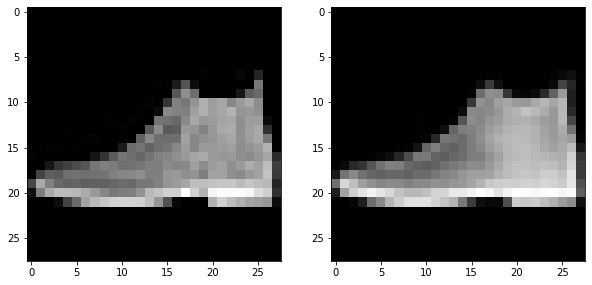

111 205.65983980635676 208.09073631603496
112 205.67563746817672 208.07308496834753
113 205.6747742892159 208.21797891927602
114 205.63519649329385 208.13608904463794
115 205.6260125567579 208.16409716133873


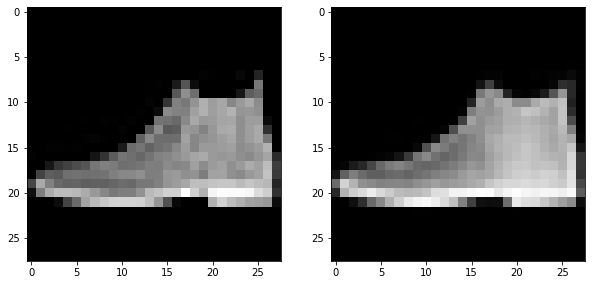

116 205.6105823530402 208.2464630809455
117 205.6002014311985 208.11299991302977
118 205.58470782813401 208.0214603411885
119 205.58011383729027 208.09992508080822
120 205.56699569257506 208.37760852167781


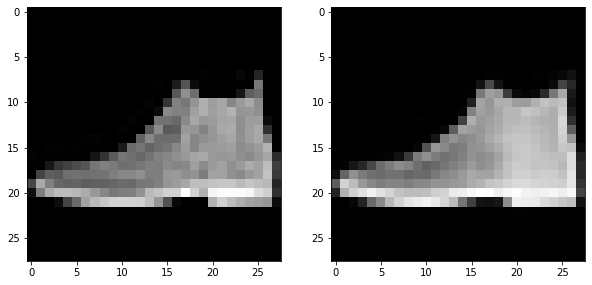

121 205.5605753971146 208.15070247954836
122 205.5501309891669 207.9177885207886
123 205.52241693969813 208.07329498388515
124 205.4986905204377 207.94414210700378
125 205.5410344409197 207.91745799494248


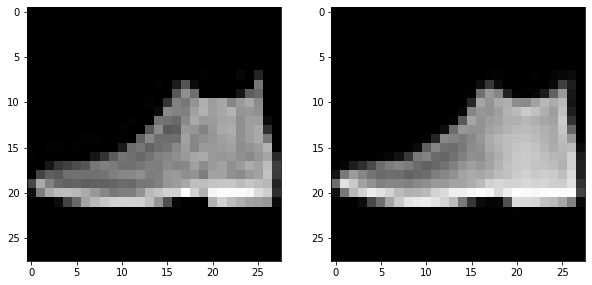

126 205.48030752956063 207.92131086355582
127 205.47641106166986 207.9454477328462
128 205.4755093398972 208.2183417177048
129 205.46730215022473 208.03833056562624
130 205.43495279080324 208.11031509740664


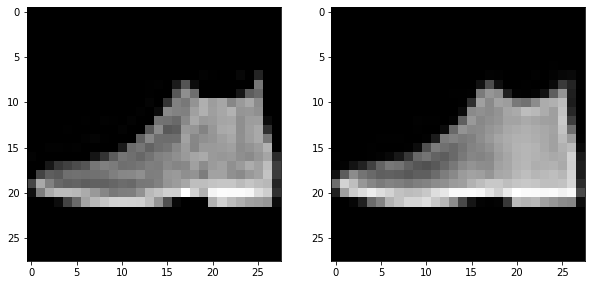

131 205.42373601917518 208.00250829142124
132 205.42925630635884 207.91356544372755
133 205.39456807931603 207.95736548085563
134 205.4346250901429 207.94146650515427
135 205.38032405937318 208.0064755765775


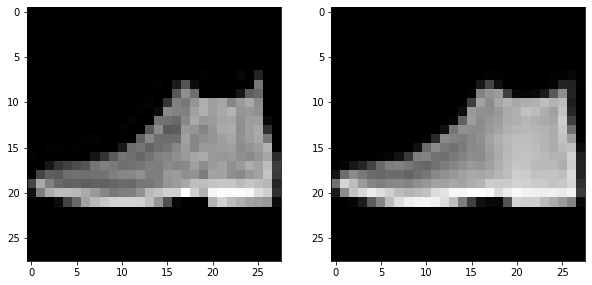

136 205.41052715678373 207.84951899226863
137 205.34945170084637 207.94189014373876
138 205.35723784771386 207.9011485919404
139 205.35624369476903 207.9027288272358
140 205.34449303904236 207.83988821011383


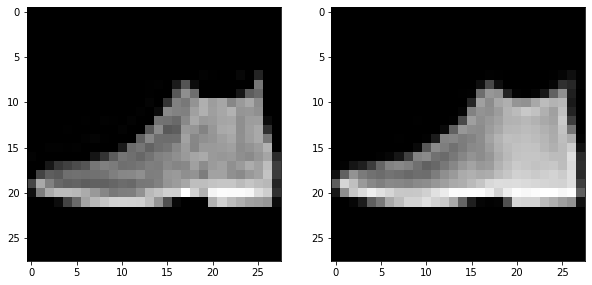

141 205.3213999625547 207.90354641557883
142 205.3297269017288 208.44140649375063
143 205.2935007470842 207.839970305324
144 205.29720053167824 207.91926667332268
145 205.29203018806638 207.9095504321991


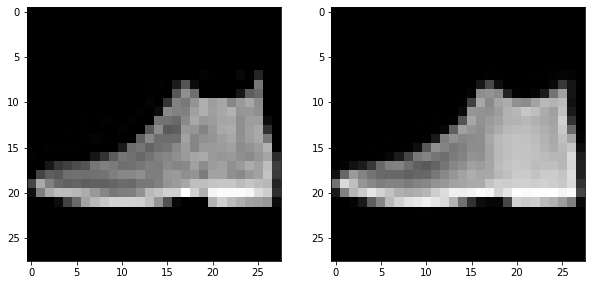

146 205.2851747297275 207.78612530498077
147 205.2628082730877 207.85265206528928
148 205.27516578831566 207.8274094944183
149 205.24491577582234 207.82640334059255
150 205.25449410921814 207.83439290104582


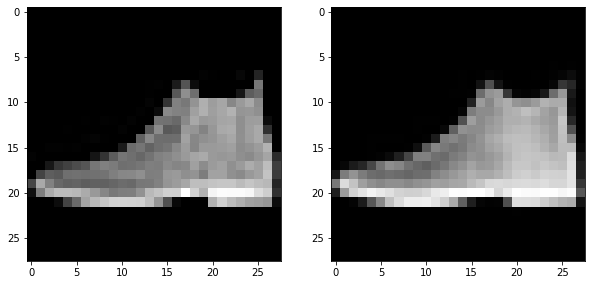

151 205.23473857562425 207.84874513278754
152 205.2071519863885 207.7967774997504
153 205.2250229348167 207.95925537694376
154 205.19183846306277 207.8156960581819
155 205.18577886932525 207.73835822644705


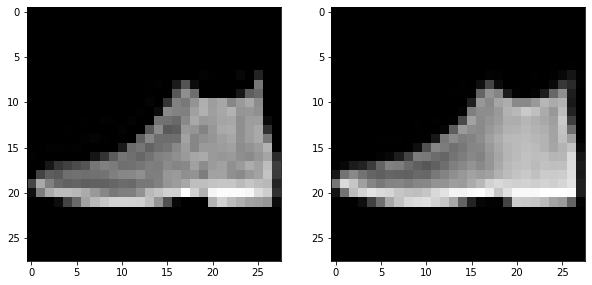

156 205.21657293844325 207.70394653710312
157 205.17554658782677 207.89564567785294
158 205.15562303403462 207.95926361571486
159 205.16502066953183 207.82128701499477
160 205.15615095343247 207.8160102039861


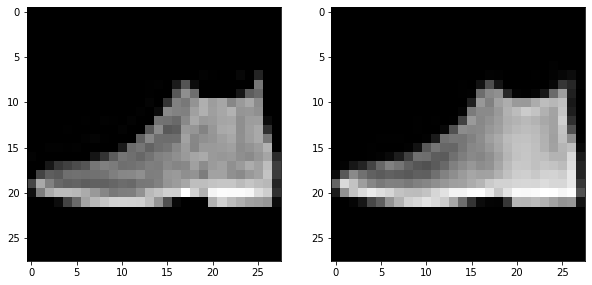

161 205.14549071007613 207.7069882036398
162 205.13267547455592 207.76154978206745
163 205.13354705832236 207.75237998109276
164 205.09916819319628 207.69429176988695
165 205.11578165256307 207.70168760257027


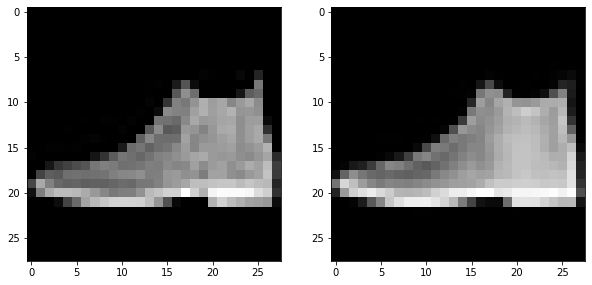

166 205.1227605585181 207.7253710957
167 205.09993647919026 207.79528910969012
168 205.09993495005787 207.84198948674307
169 205.06251017252606 207.74811566142608
170 205.06650000425122 208.03688190691767


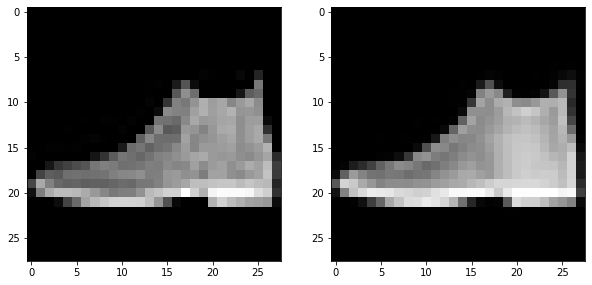

171 205.04825692356437 207.58885017370645
172 205.0297585645295 207.61241232777556
173 205.0372660839566 207.70885279841318
174 205.02546882764958 207.58439641105483
175 205.03883816218158 207.7621071909944


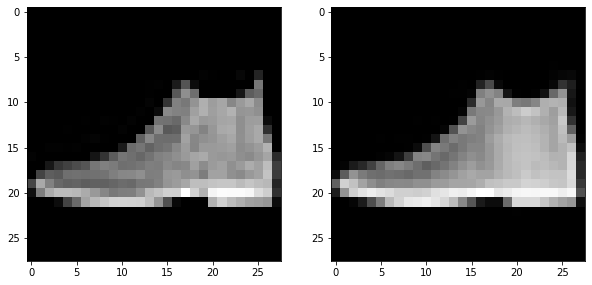

176 205.02376368237287 207.7005958922755
177 205.03184269604822 207.60578474830896
178 205.02120474982786 207.63877039900223
179 204.97824303817478 207.5862614445793
180 204.98787312348347 207.66676588942067


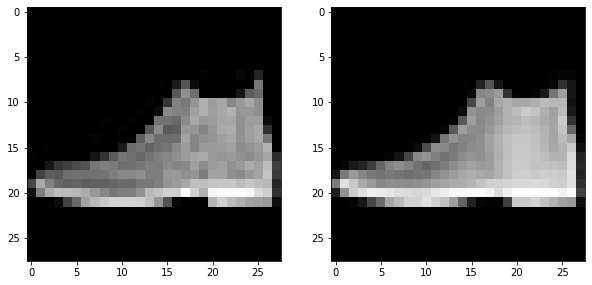

181 204.979338677792 207.7870215272751
182 204.9809675833479 207.64495318233014
183 204.97985246627147 207.66419451533795
184 204.9593521259148 207.56379134205582
185 204.93256303886193 207.6886169141093


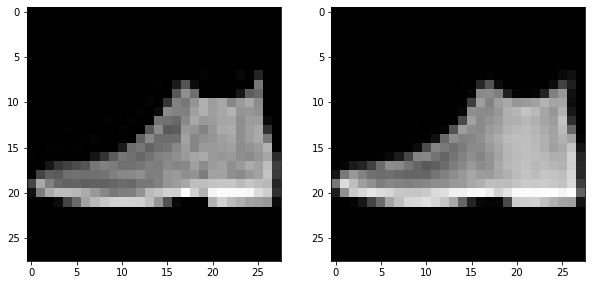

186 204.94227927613954 207.5557572239885
187 204.932611493922 207.77131340831232
188 204.93330275936168 207.59069829093764
189 204.92895421053214 207.78352034206208
190 204.91948304654184 207.67504838937387


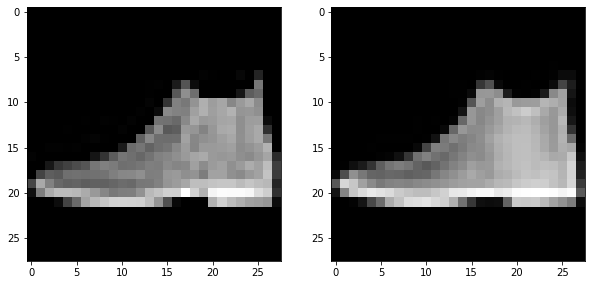

191 204.88770394504874 207.61399729183307
192 204.87965042775795 207.52242783616526
193 204.8866170355845 207.64536307337946
194 204.89779422328925 207.57817599263055
195 204.8730767418835 207.69901287822296


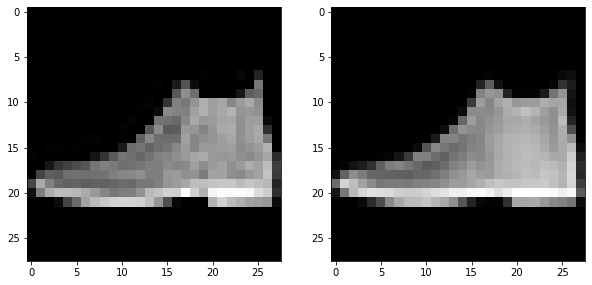

196 204.87913313637242 207.4955584736297
197 204.87569611311469 207.54132055703062
198 204.84639748123917 207.5226838230706
199 204.8521859088347 207.6105532417663
200 204.85596166202677 207.56272371432271


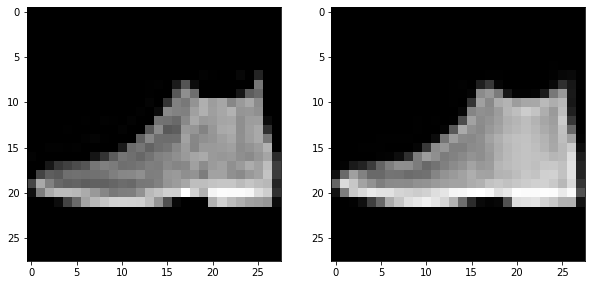

In [7]:
n_epochs = 201

pbar = trange(n_epochs)

losses = []
val_losses = []

for e in pbar:
    loss_epoch = 0
    cpt_batch = 0
    
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        
        model.train()
        
        y_hat = model(x_batch)
        l = ae_loss(x_batch, y_hat)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch += l.item()/x_batch.size(0)
        cpt_batch += 1

    losses.append(loss_epoch/cpt_batch)
    
    loss_val_epoch = 0
    cpt_batch = 0
        
    with torch.no_grad():
        for x_val, _ in test_loader:
            x_val = x_val.to(device)
            
            model.eval()
            yhat = model(x_val)            
            val_l = ae_loss(x_val,yhat)
            loss_val_epoch += val_l.item()/x_val.size(0)
            cpt_batch += 1
            
        val_losses.append(loss_val_epoch/cpt_batch)

    print(e,losses[-1],val_losses[-1])
        
    if e%5 == 0:  
        for x_val, _ in test_loader:
            fig,ax = plt.subplots(1,2,figsize=(10,10))

            ax[0].imshow(x_val[0][0],"gray")

            x_val = x_val.to(device)

            model.eval()
            yhat = model(x_val[0][0].reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
            plt.show()
            break
        
        
        

In [8]:
train_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in train_loader:
    if cpt+128>10000:
        print(cpt+128)
        train_cpu[cpt:] = data[:16,0]
    else:
        train_cpu[cpt:cpt+128] = data[:,0]
    cpt += 128
    
    if cpt>10000:
        break

# plt.imshow(real_cpu[-1],"gray")
# plt.show()

10112


In [12]:
gen_imgs = model(real_cpu.to(device).reshape(-1,1,28,28)).detach().cpu().reshape(-1,28,28,1)

evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

31.206943265425224

### Gradient Flow

In [11]:
def create_RealNVP(nh, nl, d):
    ## Add batch normalization?
    shiftings = [shifting(d//2,nh,d//2,2) for k in range(nl)]
    scalings = [scaling(d//2,nh,d//2,2) for k in range(nl)]

    flows = []
    for i in range(nl):
        flows.append(AffineCoupling(scalings[i],shiftings[i],d))
        flows.append(Reverse(d))
        flows.append(BatchNorm(d))

    model = NormalizingFlows(flows).to(device)
    return model

#### Without Entropy

In [12]:
def J(x, z, log_det):
    target = next(dataiter)[0].to(device)
    target_encoded = model.encoder(target)
    
    sw = sliced_wasserstein(x, target_encoded, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [13]:
t_init = 0
t_end = 50
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 48

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 5e-3 * np.ones(n_steps)
lrs[0] = 1e-2

n_epochs = 1000 * np.ones(n_steps)
n_epochs[0] = 3000
n_epochs[1] = 2000

Lrho = swgf_nf(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
               J=J, create_NF=create_RealNVP, nh=100, nl=5, lrs=lrs, 
               num_projections=1000, n_samples=1024, plot_loss=False, tqdm_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

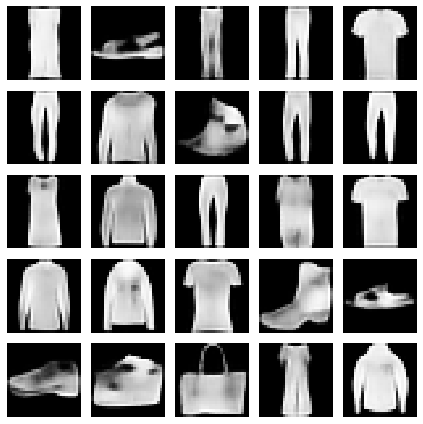

In [16]:
val_mnist_ae(Lrho[-1], model, device)

In [17]:
z = torch.randn(10000, 48, device=device)
zs, _ = Lrho[-1](z.reshape(-1,48))
gen_imgs = model.decoder(zs[-1]).detach().cpu().reshape(-1,28,28,1)

In [18]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

40.623988254619405

#### With MLP

In [17]:
class mlp(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

In [18]:
def J(rho):    
    target = next(dataiter)[0].to(device)
    target_encoded = model.encoder(target)
    
    z = torch.randn(target.size(0), target_encoded.size(1), device=device)
    x = rho(z)
    
    sw = sliced_wasserstein(x, target_encoded, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [19]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 48

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-3 * np.ones(n_steps)
lrs[0] = 5e-3

n_epochs = 1000 * np.ones(n_steps)
n_epochs[0] = 3000
n_epochs[1] = 2000

Lrho = swgf_mlp(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
                J=J, create_nn=mlp, nh=512, nl=5, lrs=lrs, 
                num_projections=1000, n_samples=1000, plot_loss=False, tqdm_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
z = torch.randn(10000, 48, device=device)
zs = Lrho[-1](z.reshape(-1,48))
gen_imgs = model.decoder(zs).detach().cpu().reshape(-1,28,28,1)

In [17]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

41.710781238657574

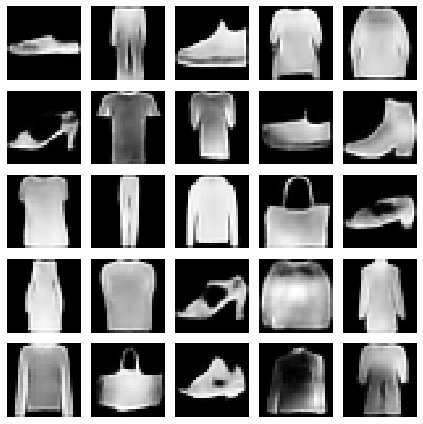

In [20]:
val_mnist_ae(Lrho[-1], model, device)

#### SWF

In [23]:
from torchinterp1d import Interp1d

In [24]:
def swf(n, d, n_epochs, dataiter, autoencoder, device=device, 
        tauk=1e-1, n_projs=50, reg=1e-4, plot=False):
    
    x0 = torch.randn(n, d, device=device)
    L = [x0.cpu().clone()]
    
    xk = x0.clone()

    percentiles = torch.linspace(0,1,100,device=device)

    pbar = trange(n_epochs)
    for k in pbar:

        if plot and k%100==0:
            print("Iteration " + str(k))
            gen_imgs = torch.zeros((10000,28,28))

            for i in range(10):
                imgs = autoencoder.decoder(xk[i*1000:(i+1)*1000].to(device)).detach().cpu().reshape(-1,28,28)
                gen_imgs[i*1000:(i+1)*1000] = imgs
                
            r, c = 5, 5
            cpt = 0
            fig,ax = plt.subplots(r,c)
            for i in range(r):
                for j in range(c):
                    ax[i,j].imshow(gen_imgs[cpt], "gray")
                    ax[i,j].axis("off")
                    cpt += 1

            fig.set_size_inches(6, 6)
            plt.tight_layout()
#             plt.suptitle("Iteration "+str(k))
            plt.show()


        theta = torch.randn(n_projs, d)
        theta = F.normalize(theta, p=2, dim=1).to(device)

        target = autoencoder.encoder(next(dataiter)[0].to(device)).detach()

        target_proj = (target@theta.T).T
        xk_proj = (xk@theta.T).T
        torch.sort(target_proj, -1)
        torch.sort(xk_proj, -1)

        xk_quantiles = torch.tensor(np.percentile(xk_proj.cpu(), percentiles.cpu()*100, axis=1), 
                                    device=device, dtype=torch.float32).T
        cdf_xk = Interp1d()(xk_quantiles, percentiles, xk_proj).detach()
        
        target_quantiles = torch.tensor(np.percentile(target_proj.cpu(), percentiles.cpu()*100, axis=1), 
                                        device=device, dtype=torch.float).T
        q = Interp1d()(percentiles.repeat(n_projs,1), target_quantiles, cdf_xk).detach()

        nabla = ((xk_proj-q)[:,None,:]*theta[:,:,None]).mean(dim=0).T

        zk = torch.randn(xk.size(), device=device)
        xk = xk - tauk * nabla + np.sqrt(2*tauk*reg) * zk
        L.append(xk.cpu().clone())
    
    return L

In [25]:
L = swf(10000, 48, 1000, dataiter, autoencoder=model, tauk=1, n_projs=1000, reg=0, plot=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
xk = L[-1]
gen_imgs = model.decoder(xk.to(device)).detach().cpu().reshape(-1,28,28,1)

evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

56.4216246133266

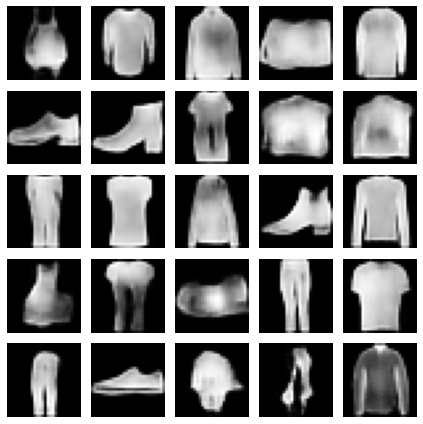

In [27]:
r, c = 5, 5
cpt = 0
fig,ax = plt.subplots(r,c)
for i in range(r):
    for j in range(c):
        ax[i,j].imshow(gen_imgs[cpt], "gray")
        ax[i,j].axis("off")
        cpt += 1

fig.set_size_inches(6, 6)
plt.tight_layout()
plt.show()